<a id="top"></a>
# Visualization of Roman APT products
***

## Server Information
IMPORTANT: To run this tutorial, please make sure you are logged in the RRN with a medium or large server. Running the parallelized examples in the advanced use cases will require a large server.


## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Imports

- *numpy* to handle array functions
- *matplotlib* for plotting data
- *astropy.table* for creating tidy tables of the data
- *pandas* for creating tidy tables of the data
- *pysiaf* to get the coordinates of WFI in different frames of reference (used internally in `footprint_utils`)
- [*healpy*](https://healpy.readthedocs.io/en/latest/) to generate all-sky maps (used internally in `footprint_utils`)
- [*hpgeom*](https://hpgeom.readthedocs.io/en/latest/#) to handle quick healpix operations (used internally in `footprint_utils`)
- [*healsparse*](https://healsparse.readthedocs.io/en/stable/index.html) to generate lightweight partial-sky high-resolution HEALPix maps
- [*skyproj*](https://skyproj.readthedocs.io/en/latest/index.html) to generate sky plots using different projections
- *dask* (Optional) to perform parallel processing

## Introduction

This notebook tries to illustrate several examples of how to visualize APT products in Python. Note that the APT GUI already has Aladdin visualization, and the tool presented in this notebook is complementary.

The utility functions defined in `footprint_utils.py` use the the so-called __simulator input__ file.
* A simulator input file, originally intended to work as input for Roman's image simulation software: `romanIsim`, contains information about all exposures and the position of the `WFI_CEN` aperture, together with duration, and filter element.


On this notebook we will demonstrate how to build visualizations of the simulator input files serially or in parallel. Note: In order to take full advantage of parallelization, the parameters (number of threads / number of processes) need to be optimized according to the machine and inputs used.


Two packages that will be used throughout the notebook are `healsparse` and `skyproj`. If  not installed already, you want to install these, please uncomment the cell below:

In [ ]:
# healsparse>=1.11.1
# %pip install ipympl
# %pip install healpy
# %pip install healsparse

In [1]:
import numpy as np
from footprint_utils import *
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import astropy.table
import ipympl

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
import healsparse as hsp
import skyproj

# Dask imports
from dask.distributed import Client, progress, as_completed
import dask.array as da
import dask
from functools import partial

By default this notebook will allow you to produce interactive plots, however, some of the plots presented here could lead to reduced performance in certain systems. In order to generate static plots, set the `interactive` variable below to `False`

In [3]:
interactive = True
if interactive:
    %matplotlib widget
else:
    %matplotlib inline

***

# Creating and loading APT outputs

The [Astronomer's Proposal Tool (APT)](https://roman-docs.stsci.edu/raug) allows the user to design a General Astrophysics Survey with the Wide Field Instrument, and it was used to design the Roman's Core Community Surveys. Given an APT program, the user can export a variety of products using the command line. In this notebook we will focus on a specific product: the `simulator input` file.

For demostration purposes, we use a subset of a program for the [High-Latitude Wide-Area Survey](https://science.nasa.gov/mission/roman-space-telescope/high-latitude-wide-area-survey/}); however, users can export these files from an specific APT program by executing the following one-line command in a terminal:

    /PATH_APT_EXECUTABLE/bin/apt -export -nogui sim /PATH_APT_FILE/my_apt_file.apt -nogui -output /PATH_TO_OUTPUT_DIRECTORY

This command will generate a simulator input file: `my_apt_file.sim.ecsv` in the output directory given in the `-output` argument. 

In the next sections we will describe what these files contain and how to read them.

## Reading a simulator input file `sim.ecsv`

The simulator input file `*.sim.ecsv` is an output from APT intended to be used as input in `romanIsim` to generate simulated images. It contains information about the position `RA, Dec` of the `WFI_CEN` aperture for eaach exposure in the program, together with information about the filter element used, and the duration in seconds (Note: duration is not exposure time, but exposure time + potential slew times / estimated overheads). These files are in `ecsv` format so they can easily be read by `pandas` or `astropy` (recommended for automatic parsing). In this example we use `astropy`.

In [4]:
# Generate the astropy table object and
# inspect the results
sim_table = astropy.table.Table.read('./aux_data/roman_hlwas.sim.ecsv')
sim_table

RA,DEC,PA,BANDPASS,MA_TABLE_NUMBER,DURATION,PLAN,PASS,SEGMENT,OBSERVATION,VISIT,EXPOSURE
float64,float64,float64,str5,int64,int64,int64,int64,int64,int64,int64,int64
151.964359,2.164771,290.0,F087,6,321,1,1,1,1,1,1
152.073363,2.216955,290.0,F087,6,321,1,1,1,1,1,2
152.245927,2.299564,290.0,F087,6,361,1,1,1,1,1,3
151.653969,1.904786,290.0,F087,6,321,1,1,1,1,2,1
151.762989,1.956986,290.0,F087,6,321,1,1,1,1,2,2
151.935585,2.039622,290.0,F087,6,361,1,1,1,1,2,3
151.343568,1.644755,290.0,F087,6,321,1,1,1,1,3,1
151.452592,1.696968,290.0,F087,6,321,1,1,1,1,3,2
151.625203,1.779626,290.0,F087,6,361,1,1,1,1,3,3


The `astropy.table.Table` object contains the `RA, DEC, PA` of the `WFI_CEN` aperture. The filter element is displayed in the `BANDAPASS` column. The[`MA_TABLE_NUMBER`](https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/observing-with-the-wfi-in-imaging-mode/wfi-multiaccum-tables) column indicates the identification number of the MultiAccum table. The `DURATION` column indicates the duration of the exposure including overheads (slews + readout, etc). `PLAN` is the [Survey Plan's](https://roman-docs.stsci.edu/raug/astronomers-proposal-tool-apt/survey-plan) number. `PASS` corresponds to the [`Pass Plan`](https://roman-docs.stsci.edu/raug/astronomers-proposal-tool-apt/pass-plans) number in APT. `SEGMENT` corresponds to the segment number in a `Pass Plan`. `OBSERVATION` corresponds to the observation number in a survey step (i.e., the pass number in a survey step and it matches `Observation` in the `obs_all` DataFrame). `VISIT` corresponds to the `Mosaic Tile` number in the mosaic segment (in the `obs_all` DataFrame). Finally, `EXPOSURE` is the exposure (dither) number for a tile.

Using this table we will visualize all the exposures in the `F158` filter and check the total exposure time.

In here, we know that exposures with `MA_TABLE_NUMBER == 5` have an exposure time of 295 seconds, whereas the exposures with `MA_TABLE_NUMBER == 6` have an exposure time of 107 seconds.


In [5]:
table_mask = sim_table['BANDPASS'] == 'F158'
sub_table = sim_table[table_mask]
exp_time = np.ones(np.count_nonzero(table_mask))
exp_time[sub_table['MA_TABLE_NUMBER'] == 6] = 295
exp_time[sub_table['MA_TABLE_NUMBER'] == 5] = 107
ra_sim = sub_table['RA'].data
dec_sim = sub_table['DEC'].data
pa_sim = sub_table['PA'].data

print('Number of selected exposures', len(sub_table))

Number of selected exposures 108348


In this case, instead of a reference position and the relative `V2`, `V3` angles, we directly have the `RA`, `DEC`, and `PA` of the `WFI_CEN` aperture, so we can use these directly via `build_single_exp_map_cen`. Let's start with a single segment within the HLWAS medium field (Survey Step 97).

In [6]:
# Setting resollution parameters used by HEALPix
nside_cov = 32  # nside_cov controls the resolution of the low-resolution coverage map (smaller = larger area coverage)
nside_sparse = 4096  # nside_sparse controls the resolution of the high-resolution map (bigger = more resolution)

Focusing on Pass Plan 97 and Segment 1, we calculate the healpixels that cover a single exposure at all pointing positions using a convenience fuction defined in `footprint_utils.py`. 

In [7]:
# Fileter Pass Plan and Segment
mask_here = (sub_table['PASS'] == 97) & (sub_table['SEGMENT'] == 1)
print('Going to use', np.count_nonzero(mask_here), 'exposures')

# Create footprint for all exposures
map_result = None
for ra, dec, pa, et in zip(ra_sim[mask_here], dec_sim[mask_here], pa_sim[mask_here], exp_time[mask_here]):
    map_here = build_single_exp_map_cen(ra, dec, pa, et, nside_cov=nside_cov, nside_sparse=nside_sparse)
    if map_result is None:
        map_result = map_here
    else:
        # map_results will have coverage from all maps
        map_result = hsp.sum_union([map_result, map_here])

Going to use 48 exposures


Now we can inspect the resulting footprint of all exposures for this Pass Plan and Segment using the interactive HEALPix map.

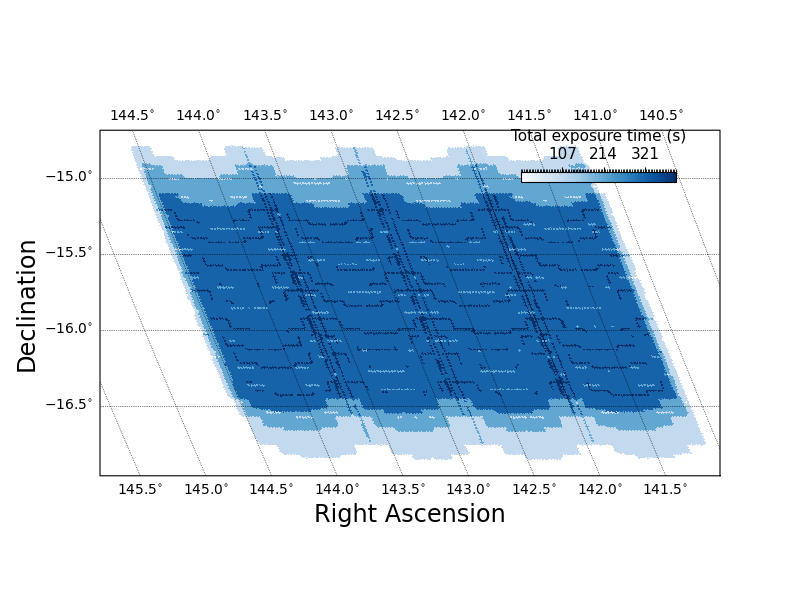

In [8]:
# Define plot parameters
fig = plt.figure(4, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)

# We define a custom colorbar for illustration purposes
# and create the new map. 
cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 400, 100)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plotting HealSparse map. 
# Note that the default is to zoom in to the range defined by the map
plot_label = 'Total exposure time (s)'
_ = sp.draw_hspmap(map_result, cmap=cmap, norm=norm)
cbar, _ = sp.draw_inset_colorbar(label=plot_label, height='3%', bbox_to_anchor=(-0.06, -0.1, 1, 1), loc=1, ticks=[107, 214, 321])  # Set up the colorbar
cbar.ax.set_xticklabels(['107', '214', '321'])
plt.show()

With large programs, executing these loops serially becomes cumbersome. Given that each segment is independent, we can parallelize the processes.

To optimizr memory usage, we split the work into niter batches and compute each batch in parallel using Dask. Once coputed, we sum the results of each batch and accumulate them into a final total map.

Note: if you have memory issues, consider increasing the batch size to niter=10 or more.

In [9]:
# Number of batches
niter = 3

In [10]:
# Starts a Dask distributed scheduler (if one isn’t already running).
client = Client(processes=True)  # In some instances processes=False will perform better

/Users/rdiaz/miniconda3/envs/footprint/lib/python3.13/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56701 instead
  warnings.warn(


Set the plot parameters. For this notebook we cap the number of exposure to 10,000 so the demo runs quickly. Please feel free to remove `nmax` below or set it to -1 in order to run for all `F158` exposures.

In [11]:
# Setting the plot parametes
table_mask = sim_table['BANDPASS'] == 'F158'
sub_table = sim_table[table_mask]
exp_time = np.ones(np.count_nonzero(table_mask))
exp_time[sub_table['MA_TABLE_NUMBER'] == 6] = 295
exp_time[sub_table['MA_TABLE_NUMBER'] == 5] = 107

# Setting up a max number of exposures
# Change to -1 in order to run for the full dataset
nmax = 10000  
ra_sim = sub_table['RA'].data[:nmax]
dec_sim = sub_table['DEC'].data[:nmax]
pa_sim = sub_table['PA'].data[:nmax]
exp_time = exp_time[:nmax]

For each iteration, `client.map()` takes a subset of the pointings and builds individual exposure maps in parallel. We then combine all those individual maps into one combined map.

In [12]:
map_all = []
for i in range(niter):
    print('Iteration', i)
    imin = (i*len(ra_sim))//niter
    imax = ((i+1)*len(ra_sim))//niter
    ra_subset = ra_sim[imin:imax]
    dec_subset = dec_sim[imin:imax]
    pa_subset = pa_sim[imin:imax]
    exp_subset = exp_time[imin:imax]

    # Build individual maps in parallel
    map_here = client.map(partial(build_single_exp_map_cen, 
                          nside_sparse=nside_sparse, nside_cov=nside_cov),
                          ra_subset, dec_subset, pa_subset, exp_subset
                          )
    
    map_partial = client.map(hsp.sum_union, [map_here])
    res_here = map_partial[0].result()
    map_all.append(res_here)

Iteration 0


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


Iteration 1
Iteration 2


In [13]:
# Close the dask client
client.close()

2025-11-25 15:39:18,413 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/rdiaz/miniconda3/envs/footprint/lib/python3.13/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/rdiaz/miniconda3/envs/footprint/lib/python3.13/site-packages/distributed/worker.py", line 1273, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
    ...<14 lines>...
    )
    ^
  File "/Users/rdiaz/miniconda3/envs/footprint/lib/python3.13/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
    ...<5 lines>...
    )
    

In [14]:
# Sum the nint batch maps into the final total exposure/coverage map
map_f158 = hsp.sum_union(map_all)

Now we can inspect the new map for all the exposures

/var/folders/dv/08hbjvn906q6z8s8d9tx94rm0005cc/T/ipykernel_69345/847759941.py:1: UserWarning: Ignoring specified arguments in this call because figure with num: 5 already exists
  fig = plt.figure(5, figsize=(10, 6))


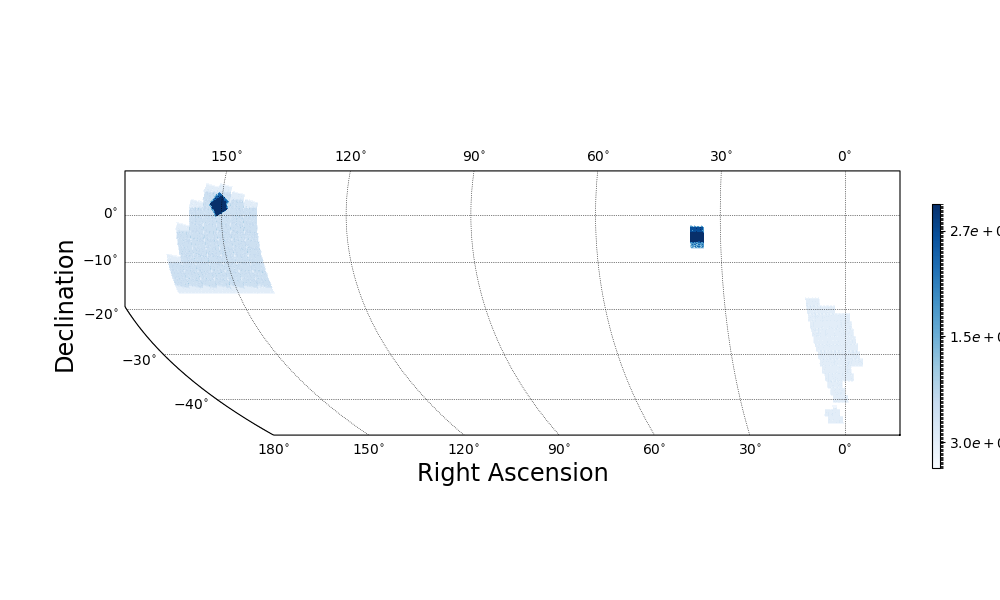

In [17]:
fig = plt.figure(5, figsize=(10, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)

cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 3000, 200)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(map_f158, cmap=cmap, norm=norm)
# Set up the colorbar
cbar, _ = sp.draw_inset_colorbar(label='Total exposure time (s)', height='100%', width='1%', orientation='vertical',
                                 bbox_to_anchor=(+0.06, -0.1, 1, 1), loc=1)
plt.show()

Note that the resulting `healsparse` maps can be saved to disk using the `write` method.

Disclaimer: Depending on the map resolution (controlled by the `nside` parameter) it can generate a very large file.

In [16]:
# map_f158.write('./data/map_f158_all.hsp')  # Uncomment if you want to write the map to disk. With the default parameters in this notebook it should use 45 MB.

## About this Notebook

**Author(s):** Javier Sánchez and Rosa Diaz <br>
**Keyword(s):** Tutorial, visualization, survey footprints <br>
**Last Updated:** Nov 2025 <br>
**Next Review:** 
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 